<h1>Содержание<span class="tocSkip"></span></h1>

* [Определение перспективного тарифа для телеком компании](#entry)
1. [Изучение данных из файлов](#research)
2. [Предобработка данных](#preprocessing)
    * [Замена типа данных](#dtype)
    * [Исправление ошибок в данных](#fxd)
    * [Обработка дубликатов](#dub)    
    * [Заполнение пропусков](#gap)
    * [Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя](#call_min)
    * [Количество отправленных сообщений по месяцам для каждого пользователя](#msg_m)
    * [Объем израсходованного интернет-трафика по месяцам для каждого пользователя](#int_m)
    * [Помесячная выручка с каждого пользователя](#pay_m)
3. [Анализ данных](#an)
* [Сколько минут разговора требуется пользователям каждого тарифа в месяц](#an_min)
    * [Сколько сообщений требуется пользователям каждого тарифа в месяц](#an_msg)
    * [Сколько интернет-трафика требуется пользователям каждого тарифа в месяц](#an_int)
4. [Проверка гипотез](#gypo)
    * [Средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковая](#gypo_tariff)
    * [Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов](#gypo_city)
5. [Общий вывод](#conc)

# Определение перспективного тарифа <a id="entry"></a>

## Изучение данных из файлов <a id="research"></a>

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
df_messages = pd.read_csv('/datasets/messages.csv')

In [3]:
df_tariffs.info()
df_tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [4]:
df_users.info()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
df_users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [6]:
df_calls.info()
df_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [7]:
df_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [8]:
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [9]:
df_internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


In [10]:
df_messages.info()
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [11]:
df_messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


**Вывод**

Представлены 5 таблиц с данными пользователей оператора мобильной связи:
1. df_tariffs - тариф: название тарифного плана, ежемесячная абонентская плата в рублях, количество минут разговора, сообщений и объем интернет-трафика в месяц, включённых в абонентскую плату, а также стоимость минуты разговора, отправки сообщения и дополнительного гигабайта интернет-трафика сверх тарифного пакета.
2. df_users - пользователи: фамилия, имя, город и возраст пользователя, название тарифного плана, дата его подключения и дата отключения (если присутствовала на момент выгрузки).
3. df_calls - звонки: имеется информация о дате звонка, его длительности, идентификатор пользователя и идентификатор самого звонка.
4. df_internet - интернет: дата использования и количество мегабайт, идентификатор самой сессии и пользователя. Какая информация представлена в столбеце Unnamed: 0 предстоит выяснить.
5. df_messages - сообщения: дата сообщения, идентификатор пользователя, отправившего сообщение и идентификатор самого сообщения.

## Предобработка данных <a class="anchor" id="preprocessing"></a>

### Замена типа данных <a class="anchor" id="dtype"></a>

In [12]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y.%m.%d %H:%M:%S')
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y.%m.%d %H:%M:%S')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y.%m.%d %H:%M:%S')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y.%m.%d %H:%M:%S')

**Вывод**

Столбцы даты переведены из типа object в тип datetime.

### Исправление ошибок в данных <a class="anchor" id="fxd"></a>

In [13]:
df_calls['duration_round'] = np.ceil(df_calls['duration'])
df_internet['mb_used_round'] = np.ceil(df_internet['mb_used'])

**Вывод**

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Добавлены столбцы в df_calls и df_internet с округленными значениями по которым ведется расчет.

### Обработка дубликатов <a class="anchor" id="dub"></a>

In [14]:
print('Дубликатов в таблице tariffs:', df_tariffs.duplicated().sum())
print('Дубликатов в таблице users:', df_users.duplicated().sum())
print('Дубликатов в таблице calls:', df_calls.duplicated().sum())
print('Дубликатов в таблице messages:', df_messages.duplicated().sum())
print('Дубликатов в таблице internet:', df_internet.duplicated().sum())

Дубликатов в таблице tariffs: 0
Дубликатов в таблице users: 0
Дубликатов в таблице calls: 0
Дубликатов в таблице messages: 0
Дубликатов в таблице internet: 0


**Вывод**

Дубликатов не найдено.

### Заполнение пропусков <a class="anchor" id="gap"></a>

In [15]:
df_users.isnull().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

**Вывод**

Пропуски присутствуют только в таблице df_users столбце даты отключения. Это значит, что данные пользователи не были отключены на момент выгрузки данных. Заполнять не нужно.

### Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя <a id="call_min"></a>

In [16]:
df_calls['month'] = df_calls['call_date'].dt.month

user_calls = df_calls.groupby(['user_id', 'month'])\
                  .agg({'duration_round':'sum', 'id':'count'})\
                  .reset_index()
user_calls.head()

,user_id,month,duration_round,id
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58


**Вывод**

Создана сводная таблица звонков и израсходованных минут по месяцам для каждого пользователя и добавлена в общую.

### Количество отправленных сообщений по месяцам для каждого пользователя <a id="msg_m"></a>

In [17]:
df_messages['month'] = df_messages['message_date'].dt.month

user_messages = df_messages.groupby(['user_id', 'month'])\
                  .agg({'id':'count'})\
                  .reset_index()
user_messages.head()

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


**Вывод**

Создана сводная таблица сообщений по месяцам для каждого пользователя и добавлена в общую.

### Объем израсходованного интернет-трафика по месяцам для каждого пользователя <a id="int_m"></a>

In [18]:
df_internet['month'] = df_internet['session_date'].dt.month

user_internet = df_internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used_round':'sum'})\
                        .reset_index()
user_internet.head()

,user_id,month,mb_used_round
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0


In [19]:
data_frames = [user_calls, user_messages, user_internet]
df = reduce(lambda  left,right: pd.merge(left,right,on=['user_id', 'month'],
                                            how='outer'), data_frames) #объединила в общую таблицу по месяцам и пользователям

In [20]:
df.head()

,user_id,month,duration_round,id_x,id_y,mb_used_round
0,1000,5,159.0,22.0,22.0,2256.0
1,1000,6,172.0,43.0,60.0,23257.0
2,1000,7,340.0,47.0,75.0,14016.0
3,1000,8,408.0,52.0,81.0,14070.0
4,1000,9,466.0,58.0,57.0,14581.0


**Вывод**

Создана сводная таблица израсходованного интернет-трафика по месяцам для каждого пользователя и добавлена в общую.

### Помесячная выручка с каждого пользователя <a id="pay_m"></a>

In [21]:
df = df.rename(columns={"user_id": "user_id", "month": "month",\
                        "duration_round": "calls_min", "id_x": "calls_sum", "id_y": "messages", "mb_used_round": "mb_used"})
              #переименовала столбцы в общей таблице для удобсвта
df = df.merge(df_users, on='user_id', how='left')

In [22]:
tariffs_dict = df_tariffs.to_dict()
tariffs_dict

{'messages_included': {0: 50, 1: 1000},
 'mb_per_month_included': {0: 15360, 1: 30720},
 'minutes_included': {0: 500, 1: 3000},
 'rub_monthly_fee': {0: 550, 1: 1950},
 'rub_per_gb': {0: 200, 1: 150},
 'rub_per_message': {0: 3, 1: 1},
 'rub_per_minute': {0: 3, 1: 1},
 'tariff_name': {0: 'smart', 1: 'ultra'}}

In [23]:
def tariff_min(row): 
    if row['tariff'] == 'ultra':
        val = tariffs_dict["minutes_included"][1]
    else:
        val = tariffs_dict["minutes_included"][0]
    return val

df['tariff_min'] = df.apply(tariff_min, axis=1)

def tariff_messages(row): 
    if row['tariff'] == 'ultra': 
        val = tariffs_dict["messages_included"][1]
    else:
        val = tariffs_dict["messages_included"][0]
    return val

df['tariff_messages'] = df.apply(tariff_messages, axis=1)

def tariff_mb(row): 
    if row['tariff'] == 'ultra':
        val = tariffs_dict["mb_per_month_included"][1]
    else:
        val = tariffs_dict["mb_per_month_included"][0]
    return val

df['tariff_mb'] = df.apply(tariff_mb, axis=1)

def tariff_cost(row): 
    if row['tariff'] == 'ultra':
        val = tariffs_dict["rub_monthly_fee"][1]
    else:
        val = tariffs_dict["rub_monthly_fee"][0]
    return val

df['tariff_cost'] = df.apply(tariff_cost, axis=1)

def min_add_cost(row): 
    if row['tariff'] == 'ultra':
        val = tariffs_dict["rub_per_minute"][1]
    else:
        val = tariffs_dict["rub_per_minute"][0]
    return val

df['min_add_cost'] = df.apply(min_add_cost, axis=1)

def message_add_cost(row): 
    if row['tariff'] == 'ultra':
        val = tariffs_dict["rub_per_message"][1]
    else:
        val = tariffs_dict["rub_per_message"][0]
    return val

df['message_add_cost'] = df.apply(message_add_cost, axis=1)

def mb_add_cost(row): 
    if row['tariff'] == 'ultra':
        val = tariffs_dict["rub_per_gb"][1]
    else:
        val = tariffs_dict["rub_per_gb"][0]
    return val

df['mb_add_cost'] = df.apply(mb_add_cost, axis=1)

In [24]:
df['min_remain'] = df['tariff_min'] - df['calls_min'] #добавляю остатки по тарифу
df['messages_remain'] = df['tariff_messages'] - df['messages']
df['mb_remain'] = (df['tariff_mb'] - df['mb_used']) / 1024 #перевожу в гб сразу

df['mb_remain'] = df['mb_remain'].round(0) #округляю до целых

In [25]:
def get_revenue(row):
    revenue_by_min = 0
    revenue_by_messages = 0
    revenue_mb = 0
    
    if row['min_remain'] < 0:
        revenue_by_min = row['min_remain'] * row['min_add_cost'] *-1
    if row['messages_remain'] < 0:
        revenue_by_messages = row['messages_remain'] * row['message_add_cost'] *-1
    if row['mb_remain'] < 0:
        revenue_mb = row['mb_remain'] * row['mb_add_cost'] *-1
    return revenue_by_min + revenue_by_messages + revenue_mb

df['add_revenue'] = df.apply(get_revenue, axis=1)

df.add_revenue = df.add_revenue.astype('float32')
df.tariff_cost = df.tariff_cost.astype('int16')

df['total_revenue'] = df['add_revenue'] + df['tariff_cost']

In [26]:
df.sort_values(by = 'total_revenue', ascending = False).head()

,user_id,month,calls_min,calls_sum,messages,mb_used,age,churn_date,city,first_name,...,tariff_mb,tariff_cost,min_add_cost,message_add_cost,mb_add_cost,min_remain,messages_remain,mb_remain,add_revenue,total_revenue
3106,1486,12,1007.0,133.0,83.0,38610.0,35,NaT,Нижний Новгород,Матвей,...,15360,550,3,3,200,-507.0,-33.0,-23.0,6220.0,6770.0
1622,1261,12,1074.0,141.0,22.0,32697.0,46,NaT,Казань,Мадина,...,15360,550,3,3,200,-574.0,28.0,-17.0,5122.0,5672.0
260,1042,12,728.0,121.0,75.0,37219.0,42,NaT,Хабаровск,Константин,...,15360,550,3,3,200,-228.0,-25.0,-21.0,4959.0,5509.0
3105,1486,11,764.0,108.0,96.0,36319.0,35,NaT,Нижний Новгород,Матвей,...,15360,550,3,3,200,-264.0,-46.0,-20.0,4930.0,5480.0
1793,1286,12,739.0,95.0,68.0,35151.0,19,NaT,Москва,Рашид,...,15360,550,3,3,200,-239.0,-18.0,-19.0,4571.0,5121.0


In [27]:
df.head()

,user_id,month,calls_min,calls_sum,messages,mb_used,age,churn_date,city,first_name,...,tariff_mb,tariff_cost,min_add_cost,message_add_cost,mb_add_cost,min_remain,messages_remain,mb_remain,add_revenue,total_revenue
0,1000,5,159.0,22.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,...,30720,1950,1,1,150,2841.0,978.0,28.0,0.0,1950.0
1,1000,6,172.0,43.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,...,30720,1950,1,1,150,2828.0,940.0,7.0,0.0,1950.0
2,1000,7,340.0,47.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,...,30720,1950,1,1,150,2660.0,925.0,16.0,0.0,1950.0
3,1000,8,408.0,52.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,...,30720,1950,1,1,150,2592.0,919.0,16.0,0.0,1950.0
4,1000,9,466.0,58.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,...,30720,1950,1,1,150,2534.0,943.0,16.0,0.0,1950.0


**Вывод**

Для расчета помесячной выручки с каждого пользователя необходимо сложить стоимость тарифа и стоимость дополнительных услуг за месяц. Для этого в общую таблицу нужно добавить стоимость тарифа в рублях и стоимость дополнительной минуты разговора, сообщения и интернет трафика. Также следует учесть, что при использовании всего трафика из пакета по тарифу пользователем считается в мегабайтах, а дополнительный трафик зачисляется по одному гигабайту. У пользователей, которые не потратили лимит из пакета по тарифу дополнительной платы за услуги не взимается.

## Анализ данных <a id="an"></a>

### Сколько минут разговора требуется пользователям каждого тарифа в месяц <a id="an_min"></a>

**С учетом нулевых (пропущенных) звонков**

In [28]:
calls_tariff_month_all = df.pivot_table(index='month', values='calls_min', columns = 'tariff', aggfunc='mean'\
                        ).sort_values(by = 'month').rename_axis(None, axis=1).reset_index()
calls_tariff_month_all

,month,smart,ultra
0,1,203.852941,428.111111
1,2,298.689655,297.125000
2,3,390.051948,489.648649
3,4,367.133929,475.301887
4,5,387.361702,534.250000
5,6,398.067485,497.469136
6,7,408.353234,564.397727
7,8,423.269231,530.611650
8,9,430.266409,558.882883
9,10,427.590444,581.728814


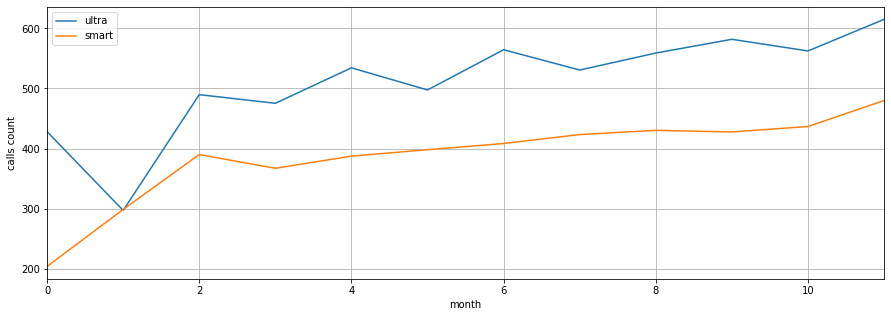

In [29]:
ax = calls_tariff_month_all.plot(y='ultra', figsize=(15, 5), grid=True) 
calls_tariff_month_all.plot(y='smart', figsize=(15, 5), grid=True, ax=ax)
ax.legend(["ultra", "smart"])
plt.xlabel('month')
plt.ylabel('calls count')
plt.show()

In [30]:
variance_estimate = np.var(calls_tariff_month_all, ddof=1)
variance_estimate

month      13.000000
smart    5296.895977
ultra    7185.123008
dtype: float64

In [31]:
standard_dev = np.std(calls_tariff_month_all, ddof=1)
standard_dev

month     3.605551
smart    72.779777
ultra    84.765105
dtype: float64

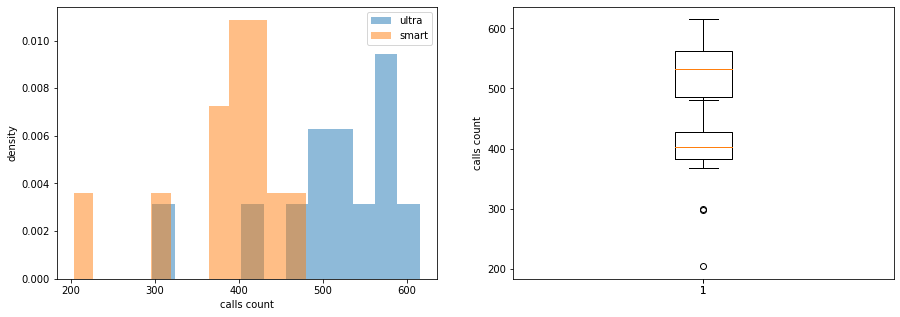

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].set(xlabel="calls count",ylabel="density")
axes[1].set(ylabel="calls count")

axes[0].hist(calls_tariff_month_all['ultra'],density=True, bins=12, alpha=0.5, label="ultra") 
axes[0].hist(calls_tariff_month_all['smart'],density=True, bins=12, alpha=0.5, label="smart")

axes[1].boxplot(calls_tariff_month_all['ultra'])
axes[1].boxplot(calls_tariff_month_all['smart'])

axes[0].legend();

plt.show()

In [33]:
calls_tariff_month_all.describe()

,month,smart,ultra
count,12.000000,12.000000,12.000000
mean,6.500000,387.605810,511.234714
std,3.605551,72.779777,84.765105
min,1.000000,203.852941,297.125000
25%,3.750000,382.304759,486.061958
50%,6.500000,403.210359,532.430825
75%,9.250000,428.259435,562.872688
max,12.000000,479.985119,614.925373


**Без учета нулевых (пропущенных) звонков**

In [34]:
df_not_zero_calls = df.query('calls_min != 0')
calls_tariff_month_not_zero = df_not_zero_calls.pivot_table(\
                                                index='month', values='calls_min',\
                                                columns = 'tariff', aggfunc='mean').sort_values(\
                                                                        by = 'month').rename_axis(None, axis=1).reset_index()
calls_tariff_month_not_zero

,month,smart,ultra
0,1,210.030303,428.111111
1,2,298.689655,310.043478
2,3,390.051948,489.648649
3,4,370.441441,475.301887
4,5,387.361702,534.250000
5,6,398.067485,497.469136
6,7,408.353234,570.885057
7,8,423.269231,535.813725
8,9,430.266409,563.963636
9,10,427.590444,581.728814


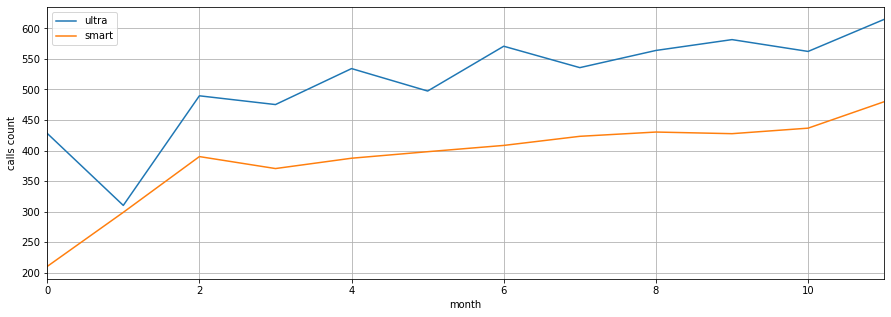

In [35]:
ax = calls_tariff_month_not_zero.plot(y='ultra', figsize=(15, 5), grid=True) 
calls_tariff_month_not_zero.plot(y='smart', figsize=(15, 5), grid=True, ax=ax)
ax.legend(["ultra", "smart"])
plt.xlabel('month')
plt.ylabel('calls count')
plt.show()

In [36]:
variance_estimate = np.var(calls_tariff_month_not_zero, ddof=1)
variance_estimate

month      13.000000
smart    5081.983668
ultra    6824.396037
dtype: float64

In [37]:
standard_dev = np.std(calls_tariff_month_not_zero, ddof=1)
standard_dev

month     3.605551
smart    71.288033
ultra    82.609903
dtype: float64

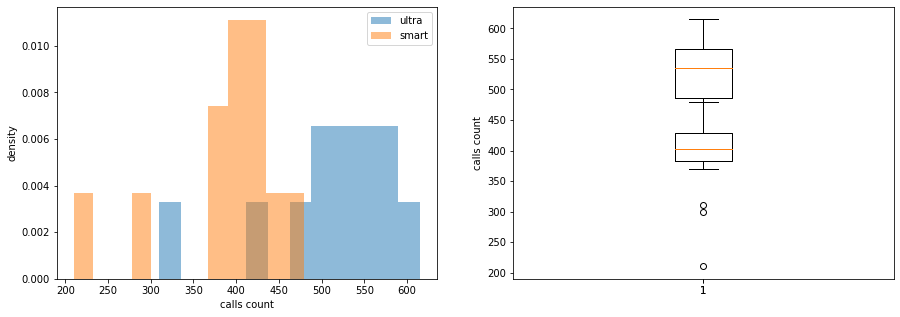

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].set(xlabel="calls count",ylabel="density")
axes[1].set(ylabel="calls count")

axes[0].hist(calls_tariff_month_not_zero['ultra'],density=True, bins=12, alpha=0.5, label="ultra") 
axes[0].hist(calls_tariff_month_not_zero['smart'],density=True, bins=12, alpha=0.5, label="smart")

axes[1].boxplot(calls_tariff_month_not_zero['ultra'])
axes[1].boxplot(calls_tariff_month_not_zero['smart'])

axes[0].legend();

plt.show()

In [39]:
calls_tariff_month_not_zero.describe()

,month,smart,ultra
count,12.000000,12.000000,12.000000
mean,6.500000,388.396216,513.708767
std,3.605551,71.288033,82.609903
min,1.000000,210.030303,310.043478
25%,3.750000,383.131637,486.061958
50%,6.500000,403.210359,535.031863
75%,9.250000,428.259435,565.693992
max,12.000000,479.985119,614.925373


**Вывод**

Большинству пользователям тарифа Ultra требуется 550 минут в месяц.

Большинству пользователей тарифа Smart требуется 400 минут в месяц.

Звонки длительностью 0 вероятно считаются пропущенными и не влияют существенно на среднее количество минут разговора. К концу года у пользователей обоих тарифов количество потраченных минут увеличивается.

### Сколько сообщений требуется пользователям каждого тарифа в месяц <a id="an_msg"></a>

In [40]:
messages_tariff_month = df.pivot_table(index='month', values='messages', columns = 'tariff', aggfunc='mean'\
                        ).sort_values(by = 'month').rename_axis(None, axis=1).reset_index()
messages_tariff_month

,month,smart,ultra
0,1,20.000000,43.428571
1,2,27.940000,32.937500
2,3,35.550725,47.800000
3,4,35.864583,44.512821
4,5,39.032787,48.769231
5,6,38.577465,52.313433
6,7,38.988506,62.136986
7,8,38.750000,58.897727
8,9,39.219731,63.294737
9,10,39.082677,69.776699


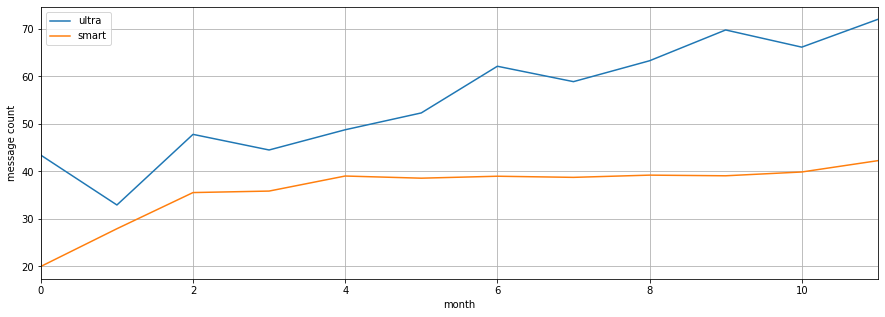

In [41]:
ax = messages_tariff_month.plot(y='ultra', figsize=(15, 5), grid=True) 
messages_tariff_month.plot(y='smart', figsize=(15, 5), grid=True, ax=ax)
ax.legend(["ultra", "smart"])
plt.xlabel('month')
plt.ylabel('message count')
plt.show()

In [42]:
variance_estimate = np.var(messages_tariff_month, ddof=1)
variance_estimate

month     13.000000
smart     38.806685
ultra    145.024587
dtype: float64

In [43]:
standard_dev = np.std(messages_tariff_month, ddof=1)
standard_dev

month     3.605551
smart     6.229501
ultra    12.042615
dtype: float64

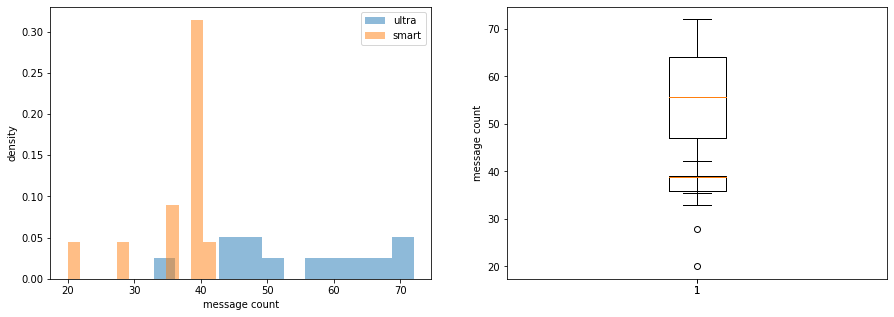

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].set(xlabel="message count",ylabel="density")
axes[1].set(ylabel="message count")

axes[0].hist(messages_tariff_month['ultra'],density=True, bins=12, alpha=0.5, label="ultra") 
axes[0].hist(messages_tariff_month['smart'],density=True, bins=12, alpha=0.5, label="smart")

axes[1].boxplot(messages_tariff_month['ultra'])
axes[1].boxplot(messages_tariff_month['smart'])

axes[0].legend();

plt.show()

In [45]:
messages_tariff_month.describe()

,month,smart,ultra
count,12.000000,12.000000,12.000000
mean,6.500000,36.262730,55.169629
std,3.605551,6.229501,12.042615
min,1.000000,20.000000,32.937500
25%,3.750000,35.786119,46.978205
50%,6.500000,38.869253,55.605580
75%,9.250000,39.116941,64.010876
max,12.000000,42.264808,72.008547


**Вывод**

Большинству пользователям тарифа Ultra требуется 65 сообщений в месяц при среднем значении 71 сообщение. Это значит, что в тарифе Ultra часть пользователей отправляют большее количество сообщений, чем большинство.

Большинству пользователей тарифа Smart требуется 40 сообщений в месяц.

К концу года у пользователей обоих тарифов количество сообщений увеличивается.

### Сколько интернет-трафика требуется пользователям каждого тарифа в месяц <a id="an_int"></a>

In [46]:
internet_tariff_month = df.pivot_table(index='month', values='mb_used', columns = 'tariff', aggfunc='mean'\
                        ).sort_values(by = 'month').rename_axis(None, axis=1).reset_index()
internet_tariff_month

,month,smart,ultra
0,1,8524.441176,13153.555556
1,2,11611.396552,12858.500000
2,3,15123.857143,17551.972973
3,4,13479.482143,16843.800000
4,5,15825.198582,19674.848485
5,6,15814.768293,19170.457831
6,7,15763.512438,20742.588889
7,8,16703.252137,19778.915094
8,9,16324.526923,19390.824561
9,10,16778.564626,20228.327869


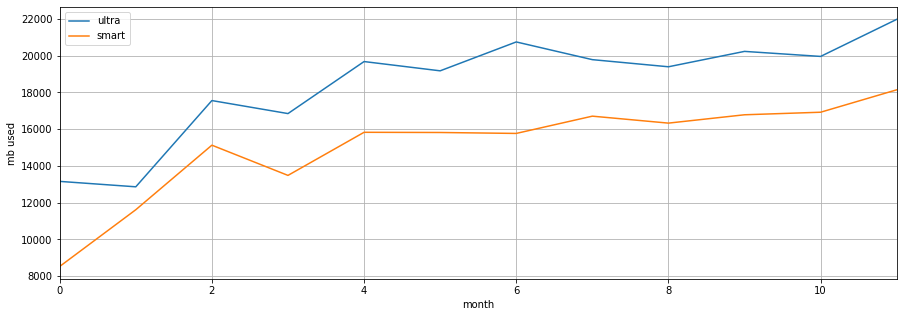

In [47]:
ax = internet_tariff_month.plot(y='ultra', figsize=(15, 5), grid=True) 
internet_tariff_month.plot(y='smart', figsize=(15, 5), grid=True, ax=ax)
ax.legend(["ultra", "smart"])
plt.xlabel('month')
plt.ylabel('mb used')
plt.show()

In [48]:
variance_estimate = np.var(internet_tariff_month, ddof=1)
variance_estimate

month    1.300000e+01
smart    7.174732e+06
ultra    8.223333e+06
dtype: float64

In [49]:
standard_dev = np.std(internet_tariff_month, ddof=1)
standard_dev

month       3.605551
smart    2678.569026
ultra    2867.635425
dtype: float64

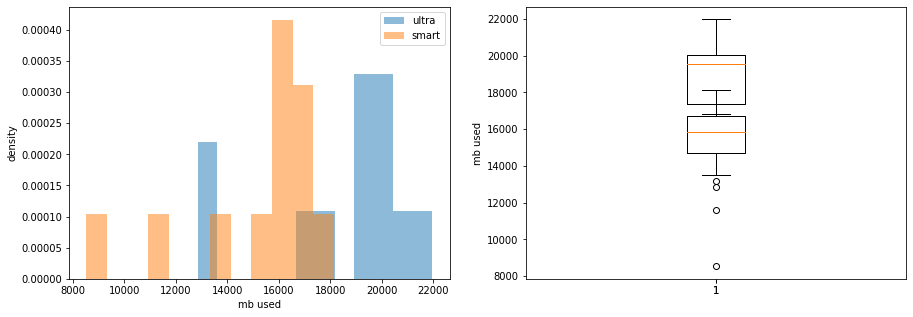

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].set(xlabel="mb used",ylabel="density")
axes[1].set(ylabel="mb used")

axes[0].hist(internet_tariff_month['ultra'],density=True, bins=12, alpha=0.5, label="ultra") 
axes[0].hist(internet_tariff_month['smart'],density=True, bins=12, alpha=0.5, label="smart")

axes[1].boxplot(internet_tariff_month['ultra'])
axes[1].boxplot(internet_tariff_month['smart'])

axes[0].legend();

plt.show()

In [51]:
internet_tariff_month.describe()

,month,smart,ultra
count,12.000000,12.000000,12.000000
mean,6.500000,15083.613790,18443.306354
std,3.605551,2678.569026,2867.635425
min,1.000000,8524.441176,12858.500000
25%,3.750000,14712.763393,17374.929730
50%,6.500000,15819.983437,19532.836523
75%,9.250000,16722.080259,20022.751140
max,12.000000,18136.833828,21971.659420


**Вывод**

Большинству пользователям тарифа Ultra требуется 19000 мегабайт или 19 гигабайт интернет-трафика.

Большинству пользователей тарифа Smart требуется 16000 мегабайт или 16 гигабайт интернет-трафика.

## Проверка гипотез <a id="gypo"></a>

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковая <a id="gypo_tariff"></a>

Нулевая гипотеза H₀: Средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковая.

Альтернативная гипотеза H₁: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Критический уровень статистической значимости 0.05

In [52]:
revenue_total_ultra = df[df['tariff'] == "ultra"]['total_revenue'].reset_index(drop=True)
revenue_total_smart = df[df['tariff'] == "smart"]['total_revenue'].reset_index(drop=True)
print(revenue_total_ultra.count())
print(revenue_total_smart.count())

985
2229


In [53]:
st.levene(revenue_total_ultra, revenue_total_smart, center='median')

LeveneResult(statistic=561.5218256930119, pvalue=1.5398685720681127e-114)

In [54]:
alpha = 0.05

results = st.ttest_ind(revenue_total_ultra, revenue_total_smart, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 1.3046950827816914e-296
Отвергаем нулевую гипотезу


In [55]:
print(revenue_total_ultra.mean())
print(revenue_total_smart.mean())

2060.1016
1231.9205


**Вывод**

p-значение: 1.4293355989555926e-172.
Отвергаем нулевую гипотезу. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Выручка от пользователей "Ультра" больше, чем от пользователей тарифа "Смарт".

### Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов <a id="gypo_city"></a>

Нулевая гипотеза H₀: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

Альтернативная гипотеза H₁: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Критический уровень статистической значимости 0.05

In [56]:
revenue_total_Moscow = df[df['city'] == "Москва"]['total_revenue'].reset_index(drop=True)
revenue_total_not_Moscow = df[df['city'] != "Москва"]['total_revenue'].reset_index(drop=True)
print(revenue_total_Moscow.count())
print(revenue_total_not_Moscow.count())

611
2603


In [57]:
st.levene(revenue_total_Moscow, revenue_total_not_Moscow, center='median')

LeveneResult(statistic=4.711189935034461, pvalue=0.03003993284436564)

In [58]:
alpha = 0.05

results = st.ttest_ind(revenue_total_Moscow, revenue_total_not_Moscow, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 0.48152450509884404
Не получилось отвергнуть нулевую гипотезу


**Вывод**

p-значение: 0.5068752446568466.
Не получилось отвергнуть нулевую гипотезу. Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

## Общий вывод <a id="conc"></a>

Следует продвигать тариф "Ультра" для потенциальных клиентов.

Средняя выручка пользователей тарифа "Ультра": 2060 рублей.

Средняя выручка пользователей тарифа "Смарт": 1231 рубль.

Большинству пользователям тарифа Ultra требуется 550 минут в месяц, 65 сообщений и 19 гигабайт трафика в месяц. В пакете услуг предоставляется 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика.

Большинству пользователей тарифа Smart требуется 400 минут в месяц, 40 сообщений и 16 гигабайт трафика в месяц. В пакете услуг предоставляется 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика. 

Пользователи тарифа «Смарт» чаще покупают дополнительные пакеты интернет-трафика.

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Пользователи тарифа «Ультра» приносят больший доход, чем пользователи тарифа «Смарт» несмотря на то, что пользователи тарифа «Смарт» чаще покупают дополнительные пакеты.

К концу года у пользователей обоих тарифов количество потраченных минут и сообщений увеличивается. В период с ноября по декабрь возможно устраивать рекламные кампании.

Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

В таблице internet был обнаружен столбец «Unnamed: 0» который дублирует индекс.

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. В таблице при изначальной выгрузке данные не были округлены. Звонки длительностью 0 вероятно считаются пропущенными и не влияют существенно на среднее количество минут разговора.